In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, MultipleLocator
import numpy as np
from scipy.interpolate import PchipInterpolator
from cmcrameri import cm

In [2]:
import utils.load_grid as lg
from proteus.config import read_config

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
pgrid_dir = "data/output/LOV_b/"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

# Case numbers
cnums = ["%d"%int(s.split("_")[-1]) for s in cases]

stts = lg.get_statuses(pgrid_dir)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)


# Configuration variables
conf = []
for f in cases:
    conf.append( read_config(f+"/init_coupler.toml") )

print("Done")

Helpfiles: 100%|██████████| 100/100 [00:03<00:00, 28.06it/s]


Done


In [5]:
def extract_scatter(case, dt, key, xend_max):
    tmp_arr = np.array(helps[case][key][3:])
    tim_arr = np.array(helps[case]["Time"][3:])

    if tmp_arr[-1] > xend_max:
        return [],[]

    # sample the evolution at equal time-spacing
    itp = PchipInterpolator(tim_arr, tmp_arr)
    look = np.arange(tim_arr[0], tim_arr[-1], dt)
    data = itp(look)
    x_arr = data[:-1]
    y_arr = data[1:]

    # x_arr = tmp_arr[:-1*dt]
    # y_arr = tmp_arr[dt:]

    # interpolate logistic map
    fact = 30
    i_arr = np.linspace(0,1,len(x_arr))
    itp = PchipInterpolator(i_arr, x_arr)
    x_arr = itp(np.linspace(0,1,len(x_arr)*fact))
    itp = PchipInterpolator(i_arr, y_arr)
    y_arr = itp(np.linspace(0,1,len(y_arr)*fact))

    return np.array(x_arr), np.array(y_arr)


In [6]:
plt.close("all")

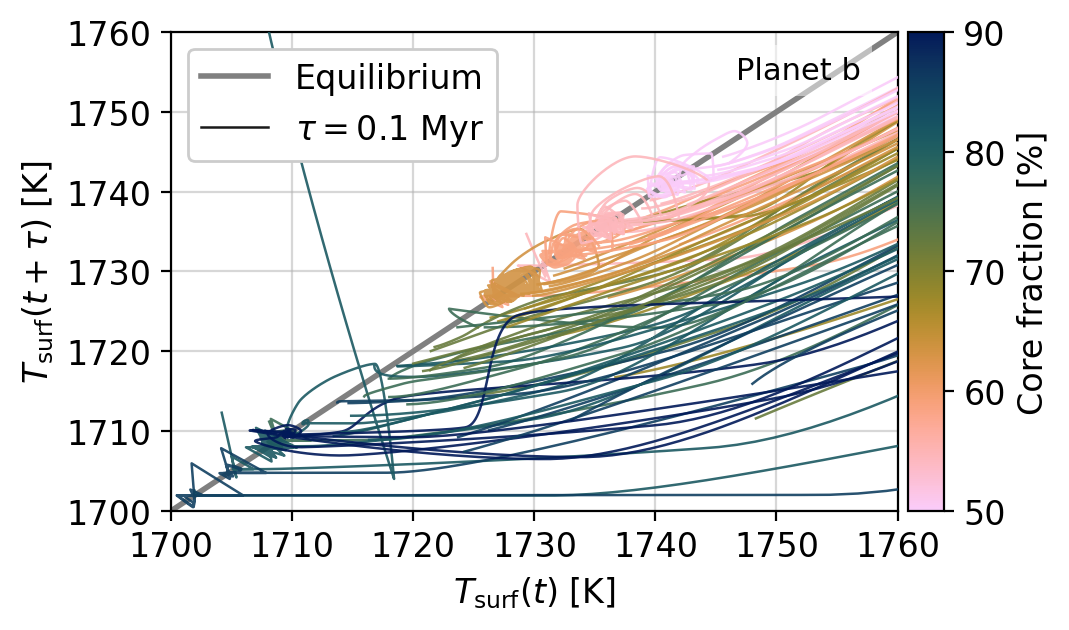

In [38]:
figscale = 1.1
fig, ax = plt.subplots(1,1, figsize=(5*figscale,3*figscale))

dt = 1e5
al = 0.9
lw = 0.9
minx = 1700
maxx = 1760
key  = "T_surf"
zvar = "struct.corefrac"
zscl = 100.0
zlbl = "Core fraction [%]"
cmap = cm.batlow_r
anno = "Planet b"

# get range of control variables
z_arr = []
for i in range(ncases):
    if "." in zvar:
        z = lg.descend_get(conf[i],zvar)
    else:
        z = helps[i][zvar][-1:]
    z_arr.append(z*zscl)

norm = mpl.colors.Normalize(vmin=np.amin(z_arr), vmax=np.amax(z_arr))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

for i in range(0,ncases,1):
    # get data
    x,y = extract_scatter(i, dt, key, maxx)
    if "." in zvar:
        z = lg.descend_get(conf[i],zvar)
    else:
        z = helps[i][zvar][-1:]

    # add to plot if data is within axis limits
    if len(x) > 1:
        ax.plot(x,y, lw=lw, alpha=al, zorder=4, color=sm.to_rgba(z*zscl))

# plot eqm line
ax.plot([0,4000], [0,4000], zorder=2, color='grey', lw=2, label="Equilibrium")

# timescale
ax.plot(-1,-1, label=r"$\tau = $%.1f Myr"%(dt/1e6), color='k', lw=lw, alpha=al)

# annotate info
axt = ax.text(0.95, 0.95, anno, zorder=12,
                horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=11)
axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

ax.set_xlim(minx, maxx)
ax.set_ylim(minx, maxx)
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_minor_locator(MultipleLocator(5))
# ax.yaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.set_xlabel(r"$T_{\text{surf}}(t)$ [K]")
ax.set_ylabel(r"$T_{\text{surf}}(t+\tau)$ [K]")
ax.grid(zorder=-3, alpha=0.5)
ax.legend(framealpha=1.0, loc='upper left')

cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(zlbl)

fig.tight_layout()
plt.show()
fig.savefig("output/logistic_recent.pdf", bbox_inches='tight')